# Safecast Solarcast device data exploration (single csv file)
### Saksham Gakhar, DA - DKSF


- Metadata for csv files is fairly intuitive -- see `df.info()` below

- Use `when_captured` field for the timestamp for a reading not `service_uploaded`. Latter is an upload time.

- The Particulate Matter (PM) measurements fall into 3 buckets -- PM2.5 means measurements of concentration of particles of size 2.5 micrometer or less and similarly for PM1.0 and PM10.0. All these 3 are measured by the devices in the dataset

- Note: the PMs are cumulative -- for more location specific insights remember you can subtract PM2.5 from PM10 and see which range of PM sizes are dominant for an area. This frames actionable insights

In [204]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
import datetime
# without mpld3
%matplotlib notebook 

In [42]:
dates = pd.date_range('2017-09-01','2020-07-01', freq='MS').strftime("%Y-%m").tolist()
dt = dates[0]
%run Run_Data_Cleansing_Solarcasts.ipynb
df = cleanSolarCastData(dt)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64655 entries, 0 to 64654
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   service_uploaded  64655 non-null  datetime64[ns, UTC]
 1   when_captured     61839 non-null  datetime64[ns, UTC]
 2   device_urn        64655 non-null  object             
 3   device_sn         64655 non-null  object             
 4   device            64655 non-null  int64              
 5   loc_lat           64655 non-null  float64            
 6   loc_lon           64655 non-null  float64            
 7   env_temp          36580 non-null  float64            
 8   env_humid         36580 non-null  float64            
 9   pms_pm01_0        36899 non-null  float64            
 10  pms_pm02_5        36898 non-null  float64            
 11  pms_pm10_0        36897 non-null  float64            
 12  lnd_7318c         55230 non-null  float64            
 13  l

Check how many devices there are in the dataset

In [408]:
df.shape

(61793, 16)

In [43]:
devices = np.unique(df.device_sn.values)
print(len(devices))
print(devices)

23
['Solarcast #30001' 'Solarcast #30003' 'Solarcast #30004'
 'Solarcast #30005' 'Solarcast #30007' 'Solarcast #30008'
 'Solarcast #30009' 'Solarcast #30012' 'Solarcast #30013'
 'Solarcast #30014' 'Solarcast #30016' 'Solarcast #30017'
 'Solarcast #30018' 'Solarcast #30019' 'Solarcast #30020'
 'Solarcast #30022' 'Solarcast #30023' 'Solarcast #30024'
 'Solarcast #30025' 'Solarcast #30026' 'Solarcast #30027'
 'Solarcast #30029' 'Solarcast #30030']


# *Sort the time series -- it's unsorted.*

In [ ]:
df.sort_values(by=['when_captured'], inplace=True)
df[0:5]

Group by device_urn

In [49]:
gf = df.groupby('device_sn')

In [59]:
def plotTimeSeries(ts):
    """
    Function to plot the time series of ts (e.g. 'bat_voltage') for all the devices in question
    args:
        ts: time series column string name "bat_voltage"
    """
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = iter(cm.rainbow(np.linspace(0, 1, len(devices))))
    for device in devices:
        s1  = gf.get_group(device)
#         print(pd.Index(s1['when_captured']).is_monotonic)
        ax.plot(s1['when_captured'].values ,s1[ts],'o-', label='{}'.format(device), color= next(colors))
    
    # Set title and labels for axes
    ax.set(xlabel="Date-Time", ylabel=ts ,title = ts)
#     ax.legend()
    plt.show()
    print(pd.Index(s1['when_captured']).is_monotonic)

Plot all the time series


<IPython.core.display.Javascript object>


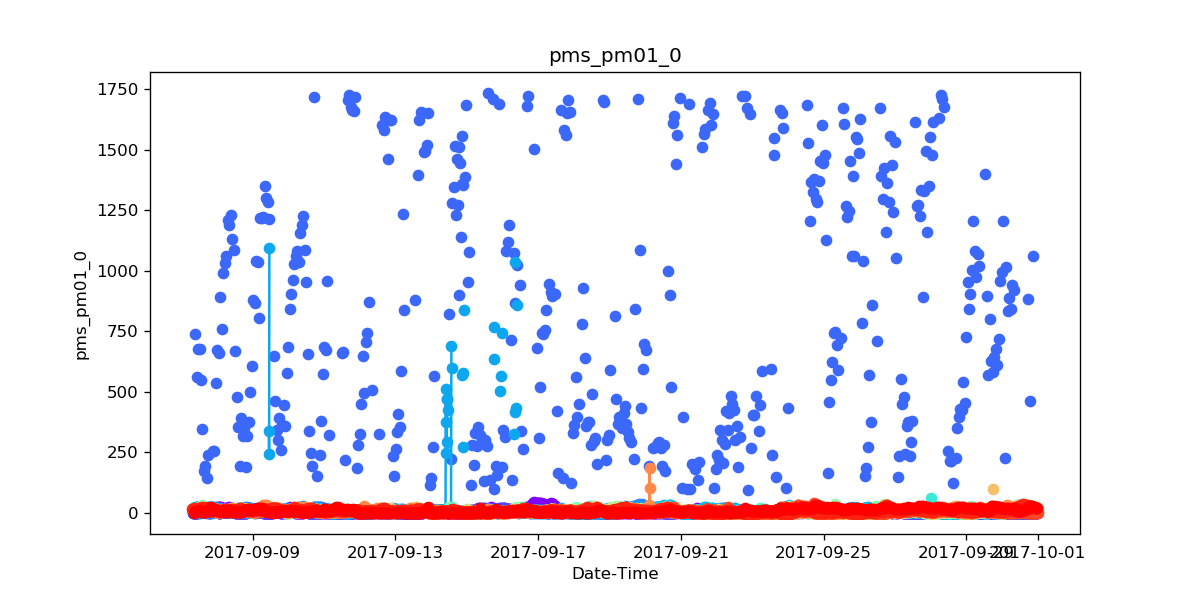

True


In [60]:
plotTimeSeries('pms_pm01_0')

<IPython.core.display.Javascript object>


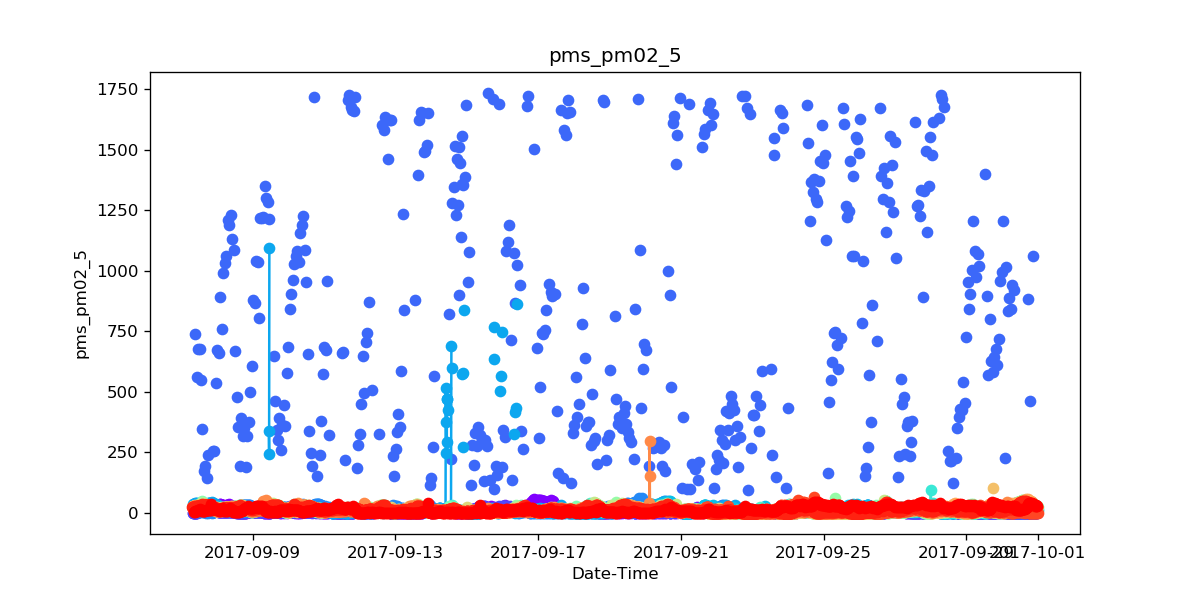

True


In [61]:
plotTimeSeries('pms_pm02_5')

<IPython.core.display.Javascript object>


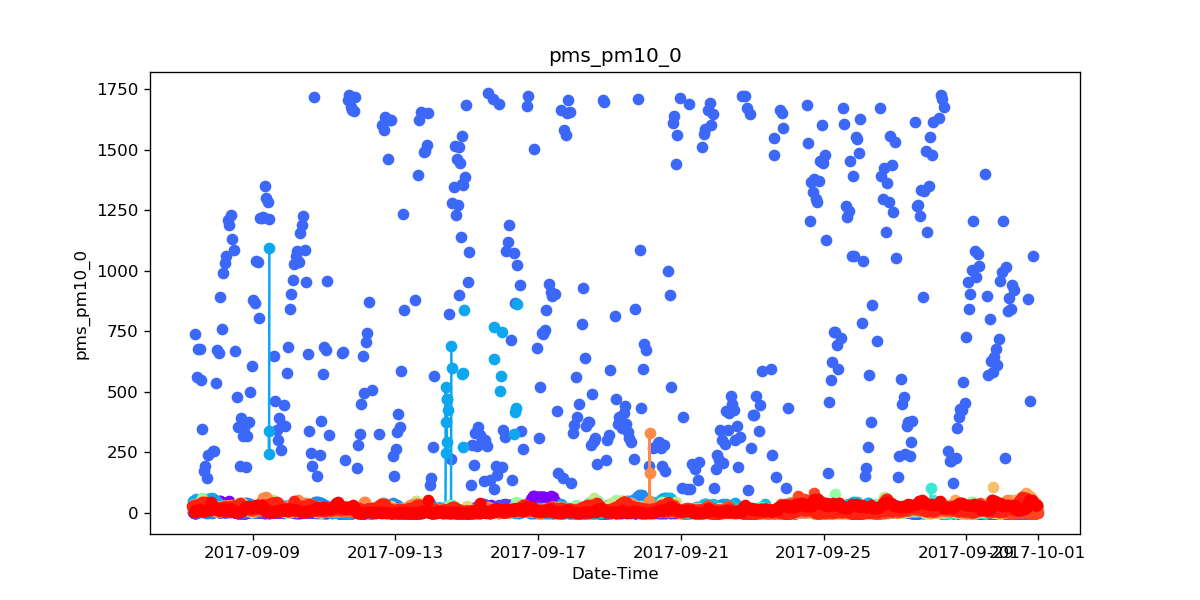

True


In [62]:
plotTimeSeries('pms_pm10_0')

<IPython.core.display.Javascript object>


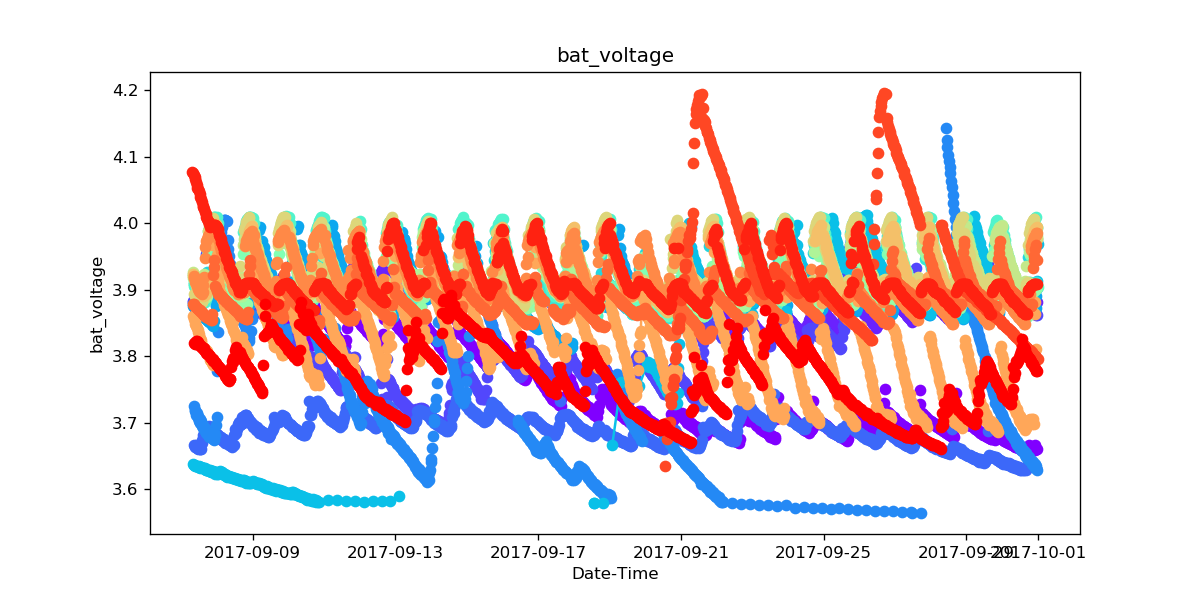

True


In [63]:
plotTimeSeries('bat_voltage')

<IPython.core.display.Javascript object>


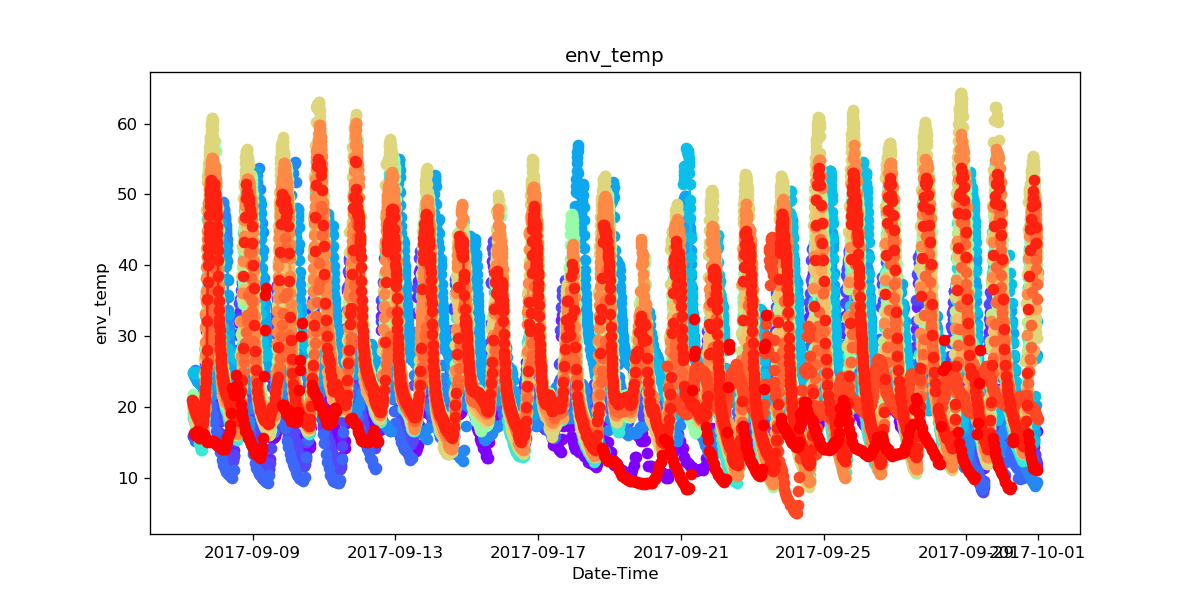

True


In [64]:
plotTimeSeries('env_temp')

<IPython.core.display.Javascript object>


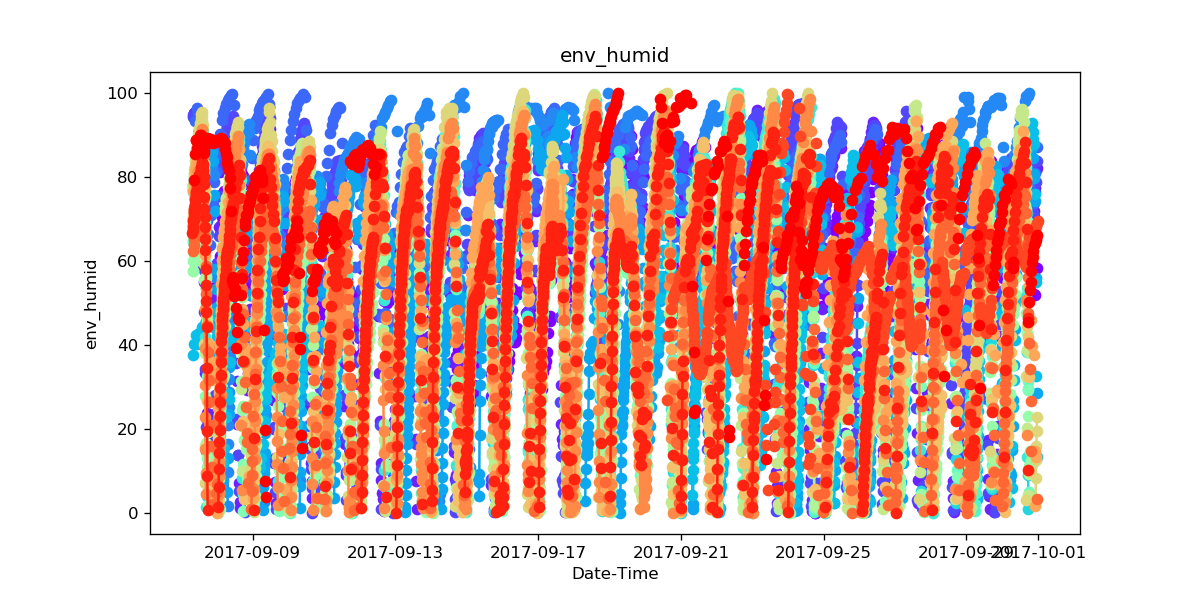

True


In [65]:
plotTimeSeries('env_humid')

<IPython.core.display.Javascript object>


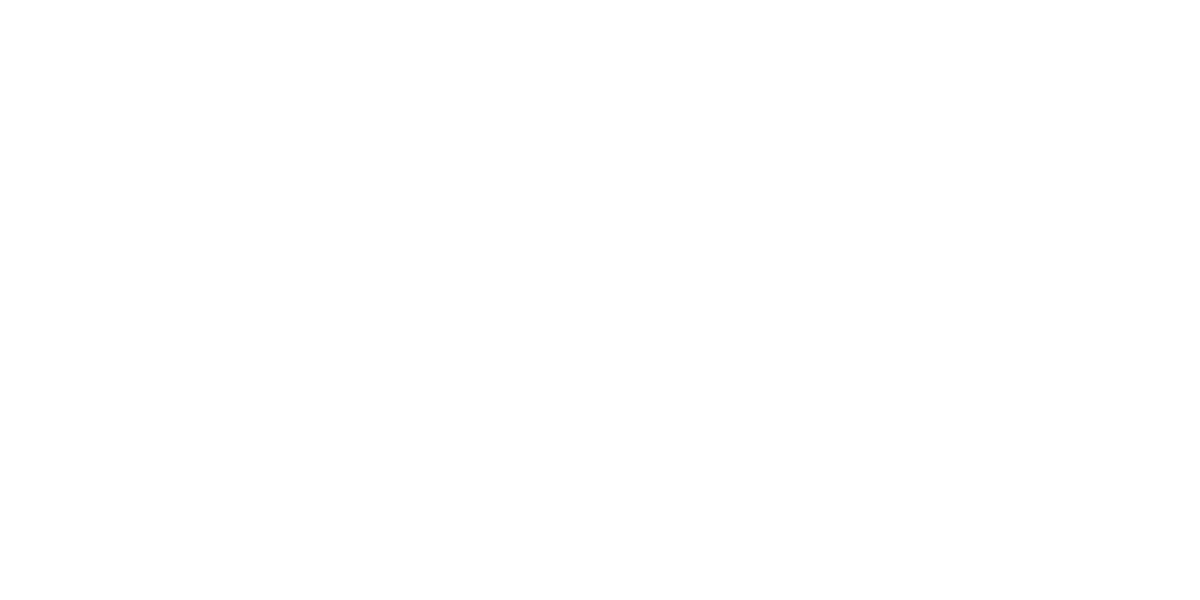

True


In [66]:
plotTimeSeries('lnd_7318c')

## Testing Luminol anomaly detection

In [714]:
import time
import luminol
from luminol.modules.time_series import TimeSeries
from luminol.utils import to_epoch
from luminol.anomaly_detector import AnomalyDetector

In [715]:
# testing luminol anomaly detection
col = 'pms_pm01_0'
dev = devices[1]

ts = df[(df['device_sn']==dev)].loc[:,['when_captured', col]]
ts = ts[ts[col].notna()]

ts_indices  = ts.when_captured.values.astype(int)
ts_data = ts[col].values
ts = pd.Series(ts_data, index=ts_indices)
ts.shape

# dt_temp = ts.iloc[0,0]
# # COnvert pandas datetime or Timestamp object to numpy datetime64 int
# pd.Timestamp.to_datetime64(ts.iloc[0,0]).astype(int)

# # COnvert numpy datetime64 int to pandas datetime or Timestamp object
# pd.to_datetime(pd.Timestamp.to_datetime64(ts.iloc[0,0]).astype(int), utc=True)

(1157,)

In [716]:
# Luminol compatible format of the time series
ts = TimeSeries(ts.to_dict())

Notes:

1. `algorithm_name='derivative_detector', algorithm_params={'smoothing_factor':0.1}` with `score_threshold` as 0.8Xmaximum score of the anomalies works well for radiation data 'lnd..c'
2. Figure out how to do anomaly detection for a series where there is periodicity
3. `algorithm_name='exp_avg_detector'` not too bad for `pms_pm01_0`. 

In [739]:
my_detector = AnomalyDetector(ts, algorithm_name='exp_avg_detector')
score = my_detector.get_all_scores()
anomalies = my_detector.get_anomalies()

In [740]:
anom_score=[]
for (timestamp, value) in score.iteritems():
    t_str = pd.to_datetime(timestamp, utc=True)
    anom_score.append([t_str, value])

In [741]:
anom_time_windows = []
for an in anomalies:
    start, end = an.get_time_window()
    anom_time_windows.append((pd.to_datetime(start, utc=True), pd.to_datetime(end, utc=True), an.anomaly_score))
#     print("Anomaly from {0} to {1} with score {2}".format\
#           (pd.to_datetime(an.start_timestamp, utc=True), \
#            pd.to_datetime(an.end_timestamp, utc=True), \
#            an.anomaly_score))

In [742]:
Ascores = [anom_time_windows[i][2] for i in range(len(anom_time_windows))]

In [743]:
len(anom_time_windows)

0

In [744]:
len(anom_score)

1157

In [745]:
len(ts)

1157

In [746]:
ts_times = pd.to_datetime(ts_indices, utc=True)
ts_times = [pd.Timestamp.to_datetime64(ts_times[i]) for i in range(len(ts_times))]

score_times = [pd.Timestamp.to_datetime64(anom_score[i][0]) for i in range(len(anom_score))]

assert(score_times==ts_times)

In [750]:
if Ascores == []:
    score_threshold = 0.1
else:
    score_threshold = 0.8*max(Ascores)
score_threshold

0.1

In [751]:
scores = [anom_score[i][1] if anom_score[i][1]> score_threshold else 0 for i in range(len(anom_score))]

<IPython.core.display.Javascript object>


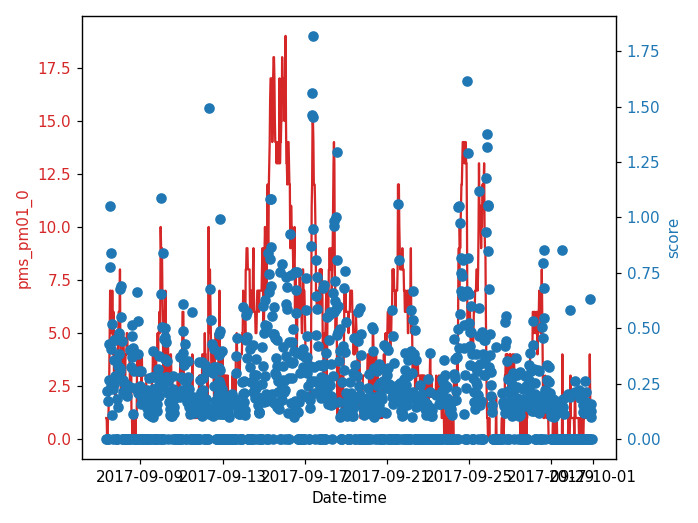

In [752]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date-time')
ax1.set_ylabel(col, color=color)
ax1.plot(ts_times, ts_data,  color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('score', color=color)  # we already handled the x-label with ax1
ax2.plot(ts_times, scores, 'o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()